In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, roc_auc_score,
    roc_curve
)

In [2]:
def evaluate_binary(y_true, y_pred, y_prob=None):
    #Returns a dict with Accuracy, TP, TN, FP, FN, Error, Recall (Sensitivity), Specificity, F1-score, AUC.
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    err = 1 - acc
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = f1_score(y_true, y_pred)
    auc = None
    if y_prob is not None:
        try:
            auc = roc_auc_score(y_true, y_prob)
        except Exception:
            auc = None
    return {
        "Accuracy": acc,
        "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "Error": err,
        "Recall (Sensitivity)": recall,
        "Specificity": specificity,
        "F1-score": f1,
        "AUC": auc
    }

In [4]:
def run_naive_bayes_pipeline(X, y, dataset_name="dataset", test_size=0.2, random_state=42):
    # Split (stratify to keep class balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Train Gaussian Naive Bayes
    model = GaussianNB()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    # For AUC, we need probabilities for the positive class
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate
    metrics = evaluate_binary(y_test, y_pred, y_prob)
    print(f"\n===== Results for {dataset_name} =====")
    for k, v in metrics.items():
        # format floats
        if isinstance(v, float):
            print(f"{k:20s}: {v:.4f}")
        else:
            print(f"{k:20s}: {v}")
    return model, metrics, y_prob

In [5]:
# 1) Breast Cancer Wisconsin (Diagnostic) -- via sklearn
df = pd.read_csv(r'C:\Users\DSC3\Desktop\yashasvi1315\WineQTDataset.csv')
df['quality label']=df['quality'].apply(lambda x:1 if x>6 else 0)
X = df.drop(columns={'quality','quality label'})  # feature column
y = df['quality label']    # target column

# Run pipeline
model_bc, metrics_bc, y_prob = run_naive_bayes_pipeline(X, y, dataset_name="Breast Cancer (sklearn)")

# Summary table
summary = pd.DataFrame({
    "wine quality": metrics_bc
}).T

pd.options.display.float_format = '{:.4f}'.format
print("\n===== Summary table =====")
display(summary)


===== Results for Breast Cancer (sklearn) =====
Accuracy            : 0.8472
TP                  : 19
TN                  : 175
FP                  : 22
FN                  : 13
Error               : 0.1528
Recall (Sensitivity): 0.5938
Specificity         : 0.8883
F1-score            : 0.5205
AUC                 : 0.7946

===== Summary table =====


,Accuracy,TP,TN,FP,FN,Error,Recall (Sensitivity),Specificity,F1-score,AUC
wine quality,0.8472,19.0000,175.0000,22.0000,13.0000,0.1528,0.5938,0.8883,0.5205,0.7946


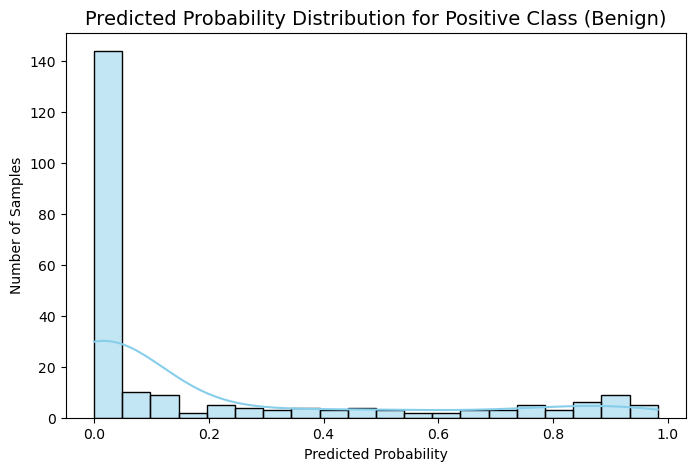

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
#Probability Distribution Plot
plt.figure(figsize=(8, 5))
sns.histplot(y_prob, bins=20, kde=True, color='skyblue')
plt.title('Predicted Probability Distribution for Positive Class (Benign)', fontsize=14)
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Samples')
plt.show()